# Geodatenanalyse 1

## Übung 9: Deterministische Interpolationsverfahren - Lösung

### 1. scipy.spatial und scipy.interpolate.griddata

Ladet zunächst mit Hilfe von pandas die Daten aus der csv-Datei ("interp_data.csv) als pandas DataFrame ein. 

Dann wollen wir ein regelmäßiges Grid von Datenpunkten erzeugen, das die Ausgabepunkte der Interpolation darstellt. Definiert dafür zuerst die Ausdehnung des Bereichs mit Hilfe von vier Variablen (z.B. xmin, max, ymin, ymax). Wendet dafür die Funktionen `.min` und `.max` auf die Spalten mit den Rechts- und Hochwerten in dem DataFrame an. Der so definierte Bereich sollte den durch die Messpunkte abgedeckten Bereich umschließen, zuzüglich eines kleinen Puffers an den Rändern. Dies könnt ihr erreichen, indem ihr auf die Maximum- und Minimumwerte einen zusätzlichen kleinen Werte dazuaddiert, bzw. abzieht.  

Fasst die vier Variablen anschließend zu einem Array zusammen (`arrays = Wert1, Wert2, Wert3, Wert4`). 

Erstellt dann zwei Arrays für die x- und y-Koordinaten der Gridpunkte. Benutzt dafür die Funktion `np.mgrid[xmin:xmax:xstep, ymin:ymax:ystep]`, und definiert zwei Outputs.  

Stellt anschließend die Grid-Punkte mit Hilfe eines Scatteplots graphisch dar, um die räumliche Verteilung zu inspizieren. 

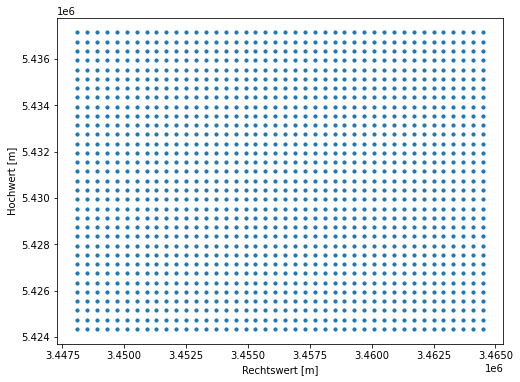

In [2]:
# [1]
# benötigte Packages laden
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Daten aus csv Datei einlesen 
data = pd.read_csv('interp_data.csv', sep=';', encoding='cp1252')

# Ausdehnung des Bereichs inklusive Puffer definieren und zusammenfassen
extent = x_min, x_max, y_min, y_max = [data.Rechtswert.min()-1000, data.Rechtswert.max()+1000,
                                       data.Hochwert.min()-1000, data.Hochwert.max()+1000]

# grid erzeugen
grid_x, grid_y = np.mgrid[x_min:x_max:400, y_min:y_max:400]

# scatterplot erzeugen
plt.figure(2, figsize=(8,6))
plt.scatter(grid_x, grid_y, s=10)
plt.xlabel('Rechtswert [m]')
plt.ylabel('Hochwert [m]')
plt.show()

Als nächstes wollen wir die Temperaturdaten mit Hilfe der Funktion `scipy.interpolate.griddata()` interpolieren. 

Als Inputs werden dafür zum Einen die Koordinaten der ursprünglichen Messpunkte als sog. Tuple benötigt. Schreibt dafür die jeweils zusammengehörigen x- und y-Koordinaten in einen gemeinsamen Array (Index [[]]). Um die reinen Zahlenwerte aus einem DataFrame zu extrahieren kann man die Funktion `.value` benutzen, also als `data[[Wert1, Wert2]].value`. 

Die Interpolationsfunktion `scipy.interpolate.griddata()` benötigt neben diesen Tupeln noch die zu interpolierenden Werte (`data.Parameter.value`) und das Grid, auf dem interpoliert werden soll, als Inputs. 

`scipy.interpolate.griddata()` unterstützt verschiedene Interpolationsfunktionen, die über den Input "method=..." spezifizert werden können: "nearest" für Nearest Neighbour, "linear" für eine einfache lineare Interpolation, und "cubic" für eine kubische Spline-Interpolation.  

Definiert drei mit diesen Methoden interpolierte Datensätze und plottet die Ergebnisse zum Vergleich nebeneinander. Zum Plotten von Rasterdaten eignet sich die Funktion `matplotlib.pyplot.imshow()`, die als Inputs das darzustellende Raster (mit `raster.T` transponiert), den Ausgangspunkt (`origin='lower'`) und die Randkoordinaten des Rasters (`extent=area`) benötigt. Als Randkoordinaten könnt ihr hier die im vorherigen Schritt als Koordinaten für die Ausdehnung des Bereichs definierte Variable nutzen. 

Wie gefallen Euch die Ergebnisse der Interpolation?

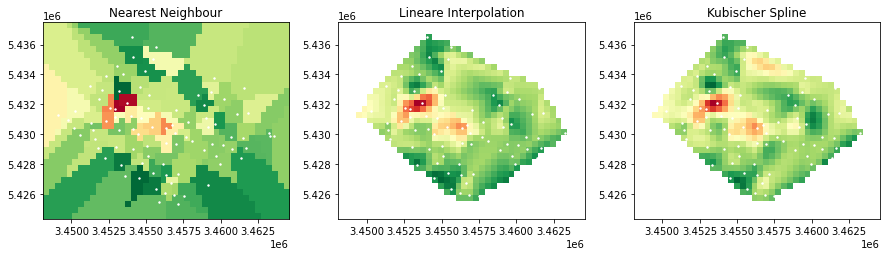

In [4]:
# [2]
# benötigte Packages laden
from scipy.interpolate import griddata

# ursprüngliche Koordinaten in Array mit Tupeln umwandeln
points = data[['Rechtswert', 'Hochwert']].values

# mit griddata drei interpolierte Datensätze erzeugen
grid_z0 = griddata(points, data.GWT.values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, data.GWT.values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, data.GWT.values, (grid_x, grid_y), method='cubic')

#  Abbildung mit 3 subplots definieren
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

ax = axs[0]
ax.imshow(grid_z0.T, origin='lower', extent=extent, cmap='RdYlGn_r')
ax.scatter(data.Rechtswert, data.Hochwert, s=2, c='w')
ax.set_title('Nearest Neighbour')

ax = axs[1]
ax.imshow(grid_z1.T, origin='lower', extent=extent, cmap='RdYlGn_r')
ax.scatter(data.Rechtswert, data.Hochwert, s=2, c='w')
ax.set_title('Lineare Interpolation')

ax = axs[2]
ax.imshow(grid_z2.T, origin='lower', extent=extent, cmap='RdYlGn_r')
ax.scatter(data.Rechtswert, data.Hochwert, s=2, c='w')
ax.set_title('Kubischer Spline')

plt.show()

### 2. scipy.interpolate.rbf

Neben den Interpolationsmethoden oben, gibt es in `scipy` auch verschiedenen Möglichkeiten zur Interpolation mit Radialen Basisfunktionen (RBFs). Die default-Einstellung von `scipy.interpolate.Rbf()` ist dabei eine Multi-quadratische Funktion, die exakt durch die Stützpunkte geht (exakte Interpolation). 

Definiert nun in dem nächsten Skript zuerst ein Interpolationsobjekt mit Hilfe von `scipy.interpolate.Rdf()`, mit den x- und y-Koordinaten Eurer Messpunkte, sowie den Messwerten als Inputs (`(x-Werte, y-Werte, Messwerte)`). 

Wendet dieses Interpolationsobjekt dann auf die x- und y-Koordinaten des Grids von oben an (`object(x-grid, y-grid)`), und visualisiert anschließend die Ergebnisse. 

Zum visuellen Vergleich der gemessenen und interpolierten Werte könnt ihr euch in der gleichen Abbildung auch die Messwerte darstellen lassen (als Scatterplot mit den Messwerten als Farbe der Punkte,`c=data.Messwerte`). 

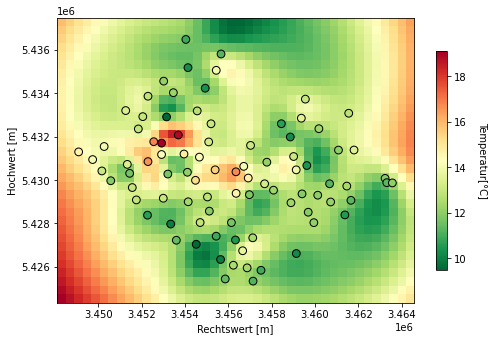

In [5]:
# [3]
# benötigte Packages laden
from scipy.interpolate import Rbf

# Interpolationsobjekt erstellen
rbfi = Rbf(data.Rechtswert, data.Hochwert, data.GWT)

# Interpolationsobjekt anwenden 
di = rbfi(grid_x, grid_y)

# Abbildung mit imshow und scatter erstellen 
plt.figure(3, figsize=(8,6))
ax = fig.add_subplot(1,1,1)

c1 = plt.imshow(di.T, origin="lower", extent=extent, cmap = 'RdYlGn_r')
c2 = plt.scatter(data.Rechtswert, data.Hochwert, s=60, c=data.GWT, edgecolor='k',  cmap = 'RdYlGn_r')

cbar = plt.colorbar(c1, shrink=0.67)
cbar.set_label(label="Temperatur[°C]", rotation=270, labelpad=20)
plt.xlabel('Rechtswert [m]')
plt.ylabel('Hochwert [m]')
plt.show()

Da die gemessenen Grundwassertemperaturen sicherlich mit gewissen Messfehlern behaftet sind, ist eine exakte Interpolation der Werte nicht unbedingt sinvoll. Mit der Angabe des Arguments `smooth=...` und einem beliebigen Werten > 0 in der Funktion `scipy.interpolate.Rbf()` geht die Interpolation nicht mehr exakt durch die Messpunkte. Damit könnt Ihr das erzeugte Bild der Grundwassertemperaturen etwas glätten.

Ergänzt eurer Skript von von oben mit dem entsprechenden Argument, und probiert verschiedenene Werte für `smooth=...` aus. 

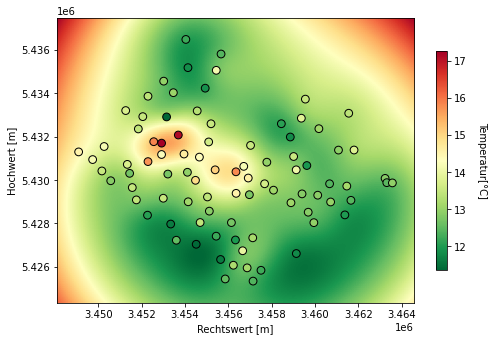

In [36]:
# [4] 
# wie [3] mit ergänztem Attribut in Interpolation
rbfi = Rbf(data.Rechtswert, data.Hochwert, data.GWT, smooth=0.2)
di = rbfi(grid_x, grid_y)

plt.figure(3, figsize=(8,6))
ax = fig.add_subplot(1,1,1)

c1 = plt.imshow(di.T, origin="lower", extent=extent, cmap = 'RdYlGn_r')
c2 = plt.scatter(data.Rechtswert, data.Hochwert, s=60, c=data.GWT, edgecolor='k',  cmap = 'RdYlGn_r')

cbar = plt.colorbar(c1, shrink=0.67)
cbar.set_label(label="Temperatur[°C]", rotation=270, labelpad=20)
plt.xlabel('Rechtswert [m]')
plt.ylabel('Hochwert [m]')
plt.show()

## Ende

### Referenzen

Menberg et al. (2013): Long-term evolution of anthropogenic heat fluxes into a subsurface urban heat island, Environ. Sci. Technol. 47(17) (2013) 9747-9755

https://colab.research.google.com/github/agile-geoscience/xlines/blob/master/notebooks/11_Gridding_map_data.ipynb